In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


np.random.seed(42)
tf.random.set_seed(42)

# Data Preparation

In [ ]:
combined_faces_zip_path = r"nput/combined_faces.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces.zip')

Done unzipping combined_faces.zip


In [ ]:
combined_faces_zip_path = r"input/combined_faces_train_augmented.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces_train_augmented.zip')

Done unzipping combined_faces_train_augmented.zip


In [ ]:
train_aug_df = pd.read_csv(r"input/images_filenames_labels_train_augmented.csv")
test_df = pd.read_csv(r"input/images_filenames_labels_test.csv")

In [ ]:
train_aug_df.head()

,filename,age
0,/content/content/combined_faces_train_augmente...,43
1,/content/content/combined_faces_train_augmente...,71
2,/content/content/combined_faces_train_augmente...,6
3,/content/content/combined_faces_train_augmente...,18
4,/content/content/combined_faces_train_augmente...,25


In [ ]:
test_df.head()

,filename,age
0,/content/content/combined_faces/8_163.jpg,8
1,/content/content/combined_faces/38_66.jpg,38
2,/content/content/combined_faces/40_177.jpg,40
3,/content/content/combined_faces/36_267.jpg,36
4,/content/content/combined_faces/8_349.jpg,8


In [ ]:
train_aug_df.shape

(234400, 2)

In [ ]:
test_df.shape

(10046, 2)

## Age classes

In [ ]:
def class_labels_reassign(age):

    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

In [ ]:
train_aug_df['target'] = train_aug_df['age'].map(class_labels_reassign)
test_df['target'] = test_df['age'].map(class_labels_reassign)

In [ ]:
train_aug_df.head()

,filename,age,target
0,/content/content/combined_faces_train_augmente...,43,4
1,/content/content/combined_faces_train_augmente...,71,6
2,/content/content/combined_faces_train_augmente...,6,1
3,/content/content/combined_faces_train_augmente...,18,2
4,/content/content/combined_faces_train_augmente...,25,3


In [ ]:
test_df.head()

,filename,age,target
0,/content/content/combined_faces/8_163.jpg,8,1
1,/content/content/combined_faces/38_66.jpg,38,4
2,/content/content/combined_faces/40_177.jpg,40,4
3,/content/content/combined_faces/36_267.jpg,36,4
4,/content/content/combined_faces/8_349.jpg,8,1


## Organize Dataset

In [ ]:
train_aug_filenames_list = list(train_aug_df['filename'])
train_aug_labels_list = list(train_aug_df['target'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

In [ ]:
train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

# Greyscale

In [ ]:
num_classes = 7

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)  
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
train_aug_dataset = train_aug_dataset.batch(512)    

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(512)   

# CNN Architecture

In [ ]:

final_cnn = Sequential()

final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(GlobalAveragePooling2D())

final_cnn.add(Dense(132, activation='relu'))

final_cnn.add(Dense(7, activation='softmax'))

final_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d (AverageP  (None, 99, 99, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 48, 48, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_2 (Averag  (None, 23, 23, 128)      0

In [ ]:
final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir=f"output/cnn_logs")

We shall also use ***ModelCheckpoint*** as a callback while training the final CNN model so as to be able to save the model as it continues training and improving in performance over 60 epochs.

In [ ]:
checkpoint = ModelCheckpoint(filepath=f"output/cnn_logs/age_model_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

# Model ftting

In [ ]:
final_cnn_history = final_cnn.fit(train_aug_dataset,
                                  batch_size=512,
                                  validation_data=test_dataset,
                                  epochs=60,
                                  callbacks=[tensorboard, checkpoint],
                                  shuffle=False   
                                 )

Epoch 1/60
458/458 [==============================] - ETA: 0s - loss: 1.8014 - accuracy: 0.3014
Epoch 00001: val_accuracy improved from -inf to 0.35736, saving model to /content/drive/My Drive/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs/age_model_checkpoint.h5
458/458 [==============================] - 159s 320ms/step - loss: 1.8014 - accuracy: 0.3014 - val_loss: 1.6051 - val_accuracy: 0.3574
Epoch 2/60
458/458 [==============================] - ETA: 0s - loss: 1.4575 - accuracy: 0.4115
Epoch 00002: val_accuracy improved from 0.35736 to 0.45331, saving model to /content/drive/My Drive/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs/age_model_checkpoint.h5
458/458 [==============================] - 136s 297ms/step - loss: 1.4575 - accuracy: 0.4115 - val_loss: 1.3222 - val_accuracy: 0.4533
Epoch 3/60
458/458 [==============================] - ETA: 0s - loss: 1.2988 - accuracy: 0.4691
Epoch 00003: val_accuracy did not improve from 0.45

# Evaluate

In [ ]:
train_loss = final_cnn_history.history['loss']
test_loss = final_cnn_history.history['val_loss']
train_accuracy = final_cnn_history.history['accuracy']
test_accuracy = final_cnn_history.history['val_accuracy']

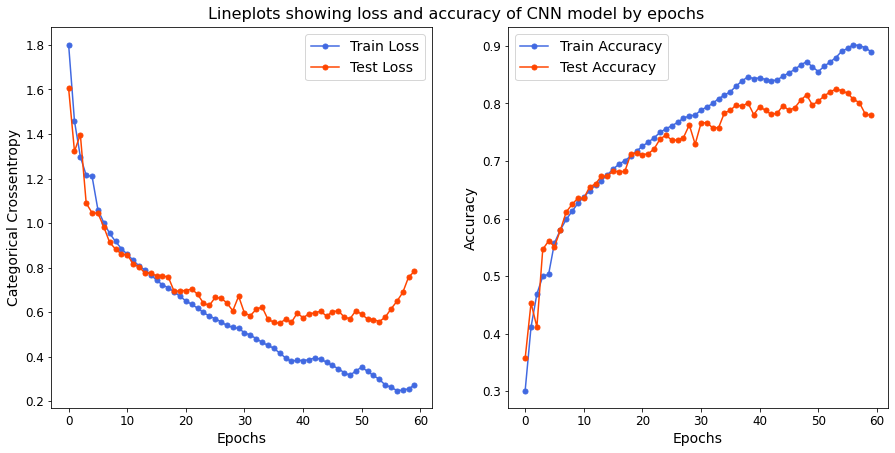

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)


In [ ]:
final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 2s 109ms/step - loss: 0.7837 - accuracy: 0.7792


In [ ]:
final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

CNN model loss 		= 0.784
CNN model accuracy 	= 0.779


In [ ]:
final_cnn.save(f"output/age_model_acc_{round(final_cnn_score[1], 3)}.h5", save_format='h5')

### Plotting Confusion Matrix

In [ ]:
final_cnn_pred = final_cnn.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)

In [ ]:
conf_mat = confusion_matrix(test_labels_list, final_cnn_pred)
conf_mat

array([[ 948,    1,    1,    1,    4,    3,    0],
       [ 164,  518,   69,   58,   26,    5,    5],
       [   3,    6,  566,  260,   91,   15,    0],
       [   1,    0,   11, 1674,  308,   13,    0],
       [   0,    0,    9,  480, 2221,   91,    6],
       [   2,    0,    0,   43,  359, 1203,   72],
       [   0,    0,    0,    8,   29,   74,  698]])